# 특징 추출

원본: https://github.com/jaron/deep-listening/blob/master/1-us8k-ffn-extract-explore.ipynb


## 패키지 설치
```shell
pip install librosa matplotlib numpy scipy
```

## ffmpeg 설치
다운 받아서 path에 등록한다.

path에 추가되어 있지 않으면 `All backends failed!` 에러가 발생합니다.

## 데이터 다운로드

2가지 데이터가 있으며, 이중에서 `UrbanSound8k`를 사용합니다.

- UrbanSound8k.tar.gz (5.6GB)


In [1]:
import glob
import os
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram

%matplotlib inline
plt.style.use('ggplot')

다음 코드를 실행하여 예제 오디오 파일을 읽어서 확인 할 수 있습니다. 

```python
filename = librosa.util.example_audio_file()
y, sr = librosa.load(filename)
```

또는 파일을 지정하여 데이터를 읽을 수 있습니다. 

```python
file = "sample/aircon.wav"
data, sr = librosa.load(file)
data
```

In [2]:
def load_sound_files(parent_dir, file_paths):
    raw_sounds = []
    for fp in file_paths:
        X, sr = librosa.load(parent_dir + fp)
        raw_sounds.append(X)
    return raw_sounds    

In [3]:
sound_file_paths = [
    'aircon.wav',
    'carhorn.wav',    
    'play.wav',
    'dogbark.wav',
    'drill.wav',
    'engine.wav',
    'gunshots.wav',
    'jackhammer.wav',
    'siren.wav',
    'music.wav'
]

sound_names = [
    'air conditioner',
    'car horn',
    'children playing',
    'dog bark',
    'drilling',
    'engine idling',
    'gun shot',
    'jackhammer',
    'siren',
    'street music'
]

parent_dir = 'sample/'

raw_sounds = load_sound_files(parent_dir, sound_file_paths)

In [4]:
def plot_waves(sound_names, raw_sounds):
    i = 1
    fig = plt.figure(figsize=(25,10), dpi= 900)
    for n, f in zip(sound_names, raw_sounds):
        plt.subplot(2,5,i)
        librosa.display.waveplot(np.array(f), sr=22050)
        plt.title(n.title())
        i += 1
    plt.suptitle('Figure 1: Waveplot', x=0.5, y=0.95, fontsize=18)
    plt.show()
    
def plot_specgram(sound_names, raw_sounds):
    i = 1
    fig = plt.figure(figsize=(25,10), dpi=900)
    for n, f in zip(sound_names, raw_sounds):
        plt.subplot(2,5,i)
        specgram(np.array(f), Fs=22050)
        plt.title(n.title())
        i += 1
    plt.suptitle('Figure 2: Spectrogram', x=0.5, y=0.95, fontsize=18)
    plt.show()
    
def plot_log_power_specgram(sound_names, raw_sounds):
    i = 1
    fig = plt.figure(figsize=(25,10), dpi=900)
    for n, f in zip(sound_names, raw_sounds):
        plt.subplot(2,5,i)
#         D = librosa.logamplitude(np.abs(librosa.stft(f))**2, ref_power=np.max)
        D = librosa.power_to_db(np.abs(librosa.stft(f))**2, ref=np.max)
        librosa.display.specshow(D, x_axis='time', y_axis='log')
        plt.title(n.title())
        i += 1
    plt.suptitle('Figure 3: Log Power spectrogram', x=0.5, y=0.95, fontsize=18)
    plt.show()
    
# plot_waves(sound_names, raw_sounds)
# plot_specgram(sound_names, raw_sounds)
# plot_log_power_specgram(sound_names, raw_sounds)

그래프 표출시에 아래와 같은 에러메시지가 나오면 config 파일을 수정합니다.

```
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.
```

config 파일 수정
```python
#c.NotebookApp.iopub_data_rate_limit = 1000000
c.NotebookApp.iopub_data_rate_limit = 1.0e10
```

In [5]:
def extract_feature(file_name):
    X, sample_rate = librosa.load(file_name)
#     print("Features: {}, sampled at {}hz".format(len(X), sample_rate))
    stft = np.abs(librosa.stft(X))
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T, axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T, axis=0)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T, axis=0)
    return mfccs, chroma, mel, contrast, tonnetz

In [6]:
sample_filename = 'sample/siren.wav'
mfccs, chroma, mel, contrast, tonnetz = extract_feature(sample_filename)
all_features = np.hstack([mfccs, chroma, mel, contrast, tonnetz])
print("MFCCS = ", len(mfccs))
print("Chroma = ", len(chroma))
print("Mel = ", len(mel))
print("Contrast = ", len(contrast))
print("Tonnetz = ", len(tonnetz))

data_points, _ = librosa.load(sample_filename)
print("IN: Initail Data Points =", len(data_points), np.shape(data_points))
print("OUT: Total features = ", len(all_features))

# print("mfccs:", mfccs)
# print("chroma:", chroma)
# print("mel:", mel)
# print("tonnetz:", tonnetz)

MFCCS =  40
Chroma =  12
Mel =  128
Contrast =  7
Tonnetz =  6
IN: Initail Data Points = 88200 (88200,)
OUT: Total features =  193


Another exploration we can perform is checking the balance of the dataset. Is there a similar number of every class label or are there some classes that appear more much often, and some classes that are rare? This is useful to know, as we could inadvertently achieve good performance on just one class with many instances, and poor performance on all others, and still seem to be achieving accurate results. Using the F1 accuracy score is important if the data is imbalanced, as it scores true and false positives equally, regardless of their class.

> 우리가 수행 할 수 있는 또 다른 탐구는 데이터 세트의 균형을 점검하는 것입니다. 비슷한 수의 모든 학급 레이블이 있습니까? 아니면 더 자주 나타나는 수업과 희귀한 클래스가 있습니까? 이는 많은 인스턴스가있는 한 클래스에서 우연히 좋은 성능을 얻을 수 있고 다른 모든 인스턴스에서는 성능이 좋지 않아 정확한 결과를 얻는 것처럼 보이기 때문에 유용합니다. F1 정확도 점수를 사용하는 것은 데이터에 불균형이있는 경우 중요하며, 클래스에 관계없이 참 및 거짓 긍정을 동등하게 채점합니다.

jupyter  에서 debugger 방법. 아래 코드를 브레이트 포인트 라인에 삽입한다.

```python
import pdb; pdb.set_trace()
```

Unique : ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']
Counts : [1000  429 1000 1000 1000 1000  374 1000  929 1000]


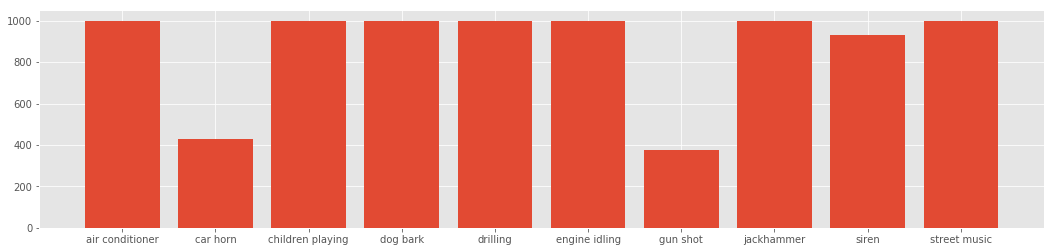

In [7]:
def get_labels(parent_dir, sub_dirs, file_ext="*.wav"):
    labels= np.empty(0)
    
    for label, sub_dir in enumerate(sub_dirs):
        for fn in glob.glob(os.path.join(parent_dir, sub_dir, file_ext)):
            try:
                class_value = fn.split('fold')[1].split('-')[1]
                labels = np.append(labels, class_value)
            except:
                print("Error processing " + fn + " - skipping")
    return labels

# put the path to the downloaded UrbanSound8K files here
raw_data_dir = 'download/UrbanSound8K/audio/'

subsequent_fold = False
for k in range(1, 11):
    fold_name = 'fold' + str(k)
    labels = get_labels(raw_data_dir, [fold_name])
    
    if subsequent_fold:
        all_labels = np.concatenate((all_labels, labels))
    else:
        all_labels = labels
        subsequent_fold = True
        
unique, counts = np.unique(all_labels, return_counts=True)

print("Unique :", unique)
print("Counts :", counts)

plt.figure(figsize=(18,4))
plt.bar(np.arange(len(unique)), counts, align="center")
plt.xticks(np.arange(len(unique)), sound_names)
plt.show()

The code in the cell below can be run (once) to convert the raw audio files into much smaller numpy arrays. As this process is quite time consuming, we'd prefer to just do it once, and then load the numpy data when we want to do some training.

> 아래의 셀에있는 코드는 원시 오디오 파일을 훨씬 작은 numpy 배열로 변환하기 위해 (한 번) 실행될 수 있습니다. 이 프로세스는 꽤 시간이 오래 걸리기 때문에 한 번 수행 한 다음 몇 가지 교육을 수행하기 위해 numpy 데이터를 로드하는 것이 좋습니다.

In [8]:
def parse_audio_files(parent_dir, sub_dirs, file_ext = '*.wav'):
    features, labels = np.empty((0, 193)), np.empty(0)
    for label, sub_dir in enumerate(sub_dirs):
        for fn in glob.glob(os.path.join(parent_dir, sub_dir, file_ext)):
            
            try:
                mfccs, chroma, mel, contrast, tonnetz = extract_feature(fn)
                ext_features = np.hstack([mfccs, chroma, mel, contrast, tonnetz])
                features = np.vstack([features, ext_features])
                labels = np.append(labels, fn.split('fold')[1].split('-')[1])
            except:
                print("Error processing {} - skipping".format(fn))
    return np.array(features), np.array(labels, dtype=np.int)

def one_hot_encode(labels):
    n_labels = len(labels)
    n_unique_labels = len(np.unique(labels))
    one_hot_encode = np.zeros((n_labels, n_unique_labels))
    one_hot_encode[np.arange(n_labels), labels] = 1
    return one_hot_encode

def assure_path_exists(path):
    mydir = os.path.join(os.getcwd(), path)
    if not os.path.exists(mydir):
        os.makedirs(mydir)

In [9]:
def save_fold(data_dir, save_dir):
    for k in range(1, 11):
        fold_name = 'fold' + str(k)
        print("Saving " + fold_name)
        features, labels = parse_audio_files(data_dir, [fold_name])
        labels = one_hot_encode(labels)
        
        print("Features of {} = {}".format(fold_name, features.shape))
        print("Labels of {} = {}".format(fold_name, labels.shape))
        
        feature_file = os.path.join(save_dir, fold_name + '_x.npy')
        labels_file = os.path.join(save_dir, fold_name + '_y.npy')
        np.save(feature_file, features)
        print("Saved ", feature_file)
        np.save(labels_file, labels)
        print("Saved ", labels_file)
        
raw_data_dir = "download/UrbanSound8K/audio/"       
save_dir = "data/us8k-np-ffn"
assure_path_exists(save_dir)
save_fold(raw_data_dir, save_dir)

Saving fold1


E:\4.SDK\Miniconda3_64\lib\site-packages\librosa\core\pitch.py:145: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


Features of fold1 = (873, 193)
Labels of fold1 = (873, 10)
Saved  data/us8k-np-ffn\fold1_x.npy
Saved  data/us8k-np-ffn\fold1_y.npy
Saving fold2
Features of fold2 = (888, 193)
Labels of fold2 = (888, 10)
Saved  data/us8k-np-ffn\fold2_x.npy
Saved  data/us8k-np-ffn\fold2_y.npy
Saving fold3
Features of fold3 = (925, 193)
Labels of fold3 = (925, 10)
Saved  data/us8k-np-ffn\fold3_x.npy
Saved  data/us8k-np-ffn\fold3_y.npy
Saving fold4
Features of fold4 = (990, 193)
Labels of fold4 = (990, 10)
Saved  data/us8k-np-ffn\fold4_x.npy
Saved  data/us8k-np-ffn\fold4_y.npy
Saving fold5
Features of fold5 = (936, 193)
Labels of fold5 = (936, 10)
Saved  data/us8k-np-ffn\fold5_x.npy
Saved  data/us8k-np-ffn\fold5_y.npy
Saving fold6
Features of fold6 = (823, 193)
Labels of fold6 = (823, 10)
Saved  data/us8k-np-ffn\fold6_x.npy
Saved  data/us8k-np-ffn\fold6_y.npy
Saving fold7
Features of fold7 = (838, 193)
Labels of fold7 = (838, 10)
Saved  data/us8k-np-ffn\fold7_x.npy
Saved  data/us8k-np-ffn\fold7_y.npy
Savin

Note: As explained in section 4.2 of https://serv.cusp.nyu.edu/projects/urbansounddataset/salamon_urbansound_acmmm14.pdf, the folds have been created by chopping up longer sound files into shorter (4 second) clips.

Hence we can't draw samples randomly across folds, as some audio clips are repetitive (like sirens and air conditioning) and that would risk segments of the same audio clip occuring in both our training and test set.

Now run notebook 2-us8k-ffn-train-evaluate, and you'll be able load the extracted features and train a model.

> 참고 : https://serv.cusp.nyu.edu/projects/urbansounddataset/salamon_urbansound_acmmm14.pdf의 4.2 절에서 설명했듯이 더 긴 사운드 파일을 짧은 (4 초) 클립으로 잘라서 폴드가 만들어졌습니다. 

> 따라서 일부 오디오 클립은 사이렌 및 에어컨과 같은 반복적 인 오디오 클립과 우리의 교육 및 테스트 세트에서 발생하는 동일한 오디오 클립의 세그먼트를 위험에 빠뜨릴 수 있으므로 폴드에 무작위로 샘플을 그릴 수는 없습니다. 

> 이제 노트북 `2-us8k-ffn-train-evaluate`을 실행하면 추출한 기능을 로드하고 모델을 학습 할 수 있습니다.
